In [ ]:
import os
from dotenv import load_dotenv



# Load environment variables
# load_dotenv()


# Set OpenAI API Key
# os.environ["OPENAI_API_KEY"]

Prompts for System behaviour



In [3]:
### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)


# Define the system prompt template
system_prompt = r"""
You are a helpful AI assistant that knows about Ulster or Ulster University based on the context provided. 

Assume all user questions are about ulster university and if you have information closely related to question asked, provide the answer.

Keep all responses short and adequate, providing enough information to answer the question without unnecessary details.

# Safety
If you feel like you do not have enough information to answer the question about ulster university, say "Can you provide more context".

If there are any questions about something other than ulster university. Kindly decline to respond

Do not forget. You only use the provided context to answer questions about ulster or ulster university.

----
{context}
----

"""

In [4]:
from PyPDF2 import PdfReader
import requests
import io

# Function to extract text from PDF documents
def extract_text_from_pdf(pdf_docs):
    text = ""
    try:
        for pdf in pdf_docs:
            # If it's a URL, download the PDF first
            if pdf.startswith('http'):
                response = requests.get(pdf)
                pdf_file = io.BytesIO(response.content)
            else:
                pdf_file = pdf
            pdf_reader = PdfReader(pdf_file)
            for page in pdf_reader.pages:
                text += page.extract_text()
    except Exception as e:
        print(f"Error processing PDF: {str(e)}")
        return None
    return text

In [5]:
url = ['ulster_data.pdf']
text = extract_text_from_pdf(url)

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from config import CHUNK_OVERLAP, CHUNK_SIZE


# Function to split text into chunks
def get_text_chunks(pdf_text):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    chunks = text_splitter.split_text(pdf_text)

    return chunks

In [7]:
chunks = get_text_chunks(text)

print(chunks[0])

ULSTER UNIVERSITY COURSES
List of courses available:
a. Artificial Intelligence – Msc
b. Computer Science – Msc
c. Internet of Things - MSc
1. Artificial Intelligence - MSc
2024/25 Full-time Postgraduate course
-------------------------------------
Award: Master of Science
Faculty: Faculty of Computing, Engineering and the Built Environment
School: School of Computing
Campus: Belfast campus
Start dates:
September 2024
January 2025
Overview
--------
Creating the next generation of high quality professionals for the AI industry.
## Summary
The MSc in Artificial Intelligence is a specialized program aimed at preparing students for careers 
in various AI-related fields, including computing, knowledge representation, reasoning, robotics, 
machine learning, deep learning, neural networks, natural language processing, and data analytics. 
It also provides a foundation for further research studies. The course is supported by advanced


In [8]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS


def create_vectorstore(text_chunks):
    vectorstore = FAISS.from_texts(
        texts=text_chunks, embedding=OpenAIEmbeddings()
    )

    return vectorstore


In [9]:
create_vector = create_vectorstore(chunks)

## Testing Cosine Similarity

In [10]:
from langchain_openai import OpenAIEmbeddings
import numpy as np

# Embedding function
def create_embedding(text):
    embeddings = OpenAIEmbeddings()
    return embeddings.embed_query(text)

In [11]:
# Calculate cosine similarity
def calc_cosine_similarity(answer_orig, answer_llm):
    vec1= create_embedding(answer_orig)
    vec2= create_embedding(answer_llm)
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [12]:
import json

with open('eval.json', 'r') as file:
    data = json.load(file)

print(len(data))

58


In [13]:
data[10]

{'id': '1a4b4f52-6094-4a81-bd2d-5b6d331ed3e4',
 'question': 'Could you detail the breakdown of the academic staff roles within the School of Computing at Ulster University, including the percentage of Professors, Readers/Senior Lecturers, and Lecturers?',
 'reference_answer': "The School of Computing's academic staff includes Professors (22%), Readers/Senior Lecturers (28%), and Lecturers (50%). Most of them hold a Postgraduate Certificate in Higher Education Practice and about 89% are HEA fellows or higher.",
 'rag_answer': 'Within the School of Computing at Ulster University, the academic staff roles are broken down as follows:\n- Professors: 22%\n- Readers/Senior Lecturers: 28%\n- Lecturers: 50%',
 '4o_answer': "I don't have the specific breakdown of academic staff roles within the School of Computing at Ulster University. For precise information, you may want to contact the university directly or visit their official website.",
 '4o_mini_answer': "I'm sorry, but I do not have speci

In [ ]:
import pandas as pd

df = pd.DataFrame([d for d in chunks], columns=["text"])
df.head(15)

# Create a Knowledge Base

In [107]:
from giskard.rag import KnowledgeBase

knowledge_base = KnowledgeBase(df)

# pip install "giskard[llm]" --upgrade


# Generate test cases

In [108]:
# from giskard.rag import generate_testset

testset = generate_testset(
    knowledge_base,
    num_questions=60,
    agent_description="A chatbot answering questions about ulster university",
)

In [110]:
# testset.save("eval.json")

In [80]:
from config import MODEL_NAME, TEMPERATURE
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.history_aware_retriever import create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import AIMessage, HumanMessage


def create_conversation_chain(vectorstore):

    llm = ChatOpenAI(
        temperature=TEMPERATURE,
        model="gpt-4o-mini",
    )

    contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
    )
    
    history_aware_retriever = create_history_aware_retriever(
        llm,
        vectorstore.as_retriever(),
        contextualize_q_prompt,
    )

    qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
    )

    question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

    rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

    return rag_chain


In [35]:
# print(MODEL_NAME)

gpt-4o


In [ ]:
from tqdm.auto import tqdm

rag = create_conversation_chain(create_vector)
# ques = ['Is AI course available?', "What is the fee?"]

hist = []
for que in tqdm(data):
    res = rag.invoke({"input": que['question'], "chat_history": hist})
    res['chat_history'].extend(
        [
            HumanMessage(content=res['input']),
            AIMessage(content=res['answer']),
        ]
    )
    
    hist = res['chat_history']

In [6]:
# hist

## Cosine Similarity

In [ ]:
# Cosine Similarity 4o_mini

similarity_4o_mini = []

for record in tqdm(data):
    rag_similarity_4o_mini = calc_cosine_similarity(record["reference_answer"], record["4o_mini"])
    similarity_4o_mini.append(rag_similarity_4o_mini)

In [9]:
# print(similarity_4o_mini)

[0.97333597413242, 0.9941593435283048, 0.928090006325733, 0.930599075580288, 0.9777510057045927, 0.968519888528558, 0.8904244216669615, 0.9935565726128979, 0.9121512341212564, 0.9198812995822994, 0.9455839574676895, 0.941776212799846, 0.8624234144247869, 0.9093272857860851, 0.9871251819730256, 0.863472557124301, 0.93768370849917, 0.9362407186444849, 0.9692688650659721, 0.9413027824696996, 0.9624342241366374, 0.8664323227183953, 0.8935179308797724, 0.9432515697474604, 0.9624084707728009, 0.8761708273421341, 0.9571311119891801, 0.9756268153992277, 0.9318744733506718, 0.9166733416819074, 0.8347092165681722, 0.9719153528923428, 0.9712652975221702, 0.9922011419182464, 0.9317650624625209, 0.907198098247873, 0.9739954235627571, 0.9732151365761114, 0.9583705204141909, 0.893299123283583, 0.984399428302752, 0.9922489929630032, 0.9835667213530122, 0.9513789594094336, 0.9440623905001735, 0.9189706869088077, 0.8532551102250173, 0.9728160257055198, 0.9574637004936, 0.8587290848260151, 0.917866792069

In [ ]:
# Cosine Similarity 4o

similarity_4o = []

for record in tqdm(data):
    rag_similarity_4o = calc_cosine_similarity(record["reference_answer"], record["4o"])
    similarity_4o.append(rag_similarity_4o)


In [11]:
# print(similarity_4o)

[0.9821809162944978, 0.9941418046343126, 0.928090006325733, 0.9305910441087046, 0.9781853881435718, 0.9684889471358848, 0.9099588176660355, 0.9935565726128979, 0.9344887114952317, 0.9323035951618673, 0.9607557034664519, 0.9473621989394728, 0.8706197016912158, 0.9336483658825407, 0.9856302623999406, 0.8613660316547231, 0.9383311309815533, 0.9428804665756995, 0.9665695454785891, 0.9299898105868992, 0.9738844071243921, 0.9098421508302489, 0.918078081352373, 0.9432288614231932, 0.9624181833882598, 0.8832109981740701, 0.9590635542375802, 0.9774232417063726, 0.9638888963162479, 0.9154012697959106, 0.835932771628298, 0.9750524334213594, 0.9712652975221702, 0.9922771296184469, 0.9638888963162479, 0.9129599110699584, 0.9623804076058611, 0.9732151365761114, 0.9583705204141909, 0.8927369486102935, 0.9880495479949617, 0.9948663436124884, 0.9884103266358429, 0.9526683470430956, 0.9484086348278035, 0.9540260755996217, 0.8571344955422494, 0.9708934218740531, 0.9574637004936, 0.8585828110043822, 0.921

In [ ]:
# Cosine Similarity 35_turbo

similarity_35_turbo = []

for record in tqdm(data):
    rag_similarity_35 = calc_cosine_similarity(record["reference_answer"], record["3.5_turbo"])
    similarity_35_turbo.append(rag_similarity_35)
    

In [13]:
# print(similarity_35_turbo)

[0.9833343269766263, 0.9941751152693861, 0.928090006325733, 0.9305910441087046, 0.978263427990623, 0.9681006562802313, 0.9264551385498725, 0.9935565726128979, 0.8924219850687876, 0.9354936338666717, 0.9605327455748617, 0.9494261445866913, 0.8258071203420654, 0.9300952734286378, 0.980078705887503, 0.8985720323531472, 0.939172821694388, 0.9428726425386486, 0.9039456597972881, 0.9215014386449648, 0.7263578472626674, 0.8529957708028497, 0.9094239477951743, 0.9432515697474604, 0.9591553234440621, 0.8379013091567682, 0.9614271591689159, 0.9784254521165276, 0.9572444208786325, 0.9067693117246478, 0.8404973721863502, 0.9866490139498529, 0.9716769239350487, 0.9735885477619948, 0.9572444208786325, 0.8987046003857226, 0.9409283830936515, 0.9701762646691348, 0.9480228819761687, 0.8825948129500462, 0.9784106888977538, 0.9903810985607786, 0.9829026485810708, 0.9455795009892101, 0.9590374498984929, 0.9208426511432992, 0.8550434804925228, 0.9735744310593403, 0.9526747323879539, 0.8586689354291767, 0.9

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

series_4o = pd.Series(similarity_4o)
series_4o_mini = pd.Series(similarity_4o_mini)
series_35 = pd.Series(similarity_35_turbo)
# summary_stats = series_4o.describe() 

In [15]:
series_4o_mini.describe()



count    66.000000
mean      0.927403
std       0.053287
min       0.719444
25%       0.905680
50%       0.936962
75%       0.970766
max       0.994159
dtype: float64

In [16]:
series_4o.describe()

count    66.000000
mean      0.935633
std       0.048848
min       0.719457
25%       0.919024
50%       0.945486
75%       0.970292
max       0.994866
dtype: float64

In [17]:
series_35.describe()

count    66.000000
mean      0.921110
std       0.059249
min       0.719457
25%       0.900015
50%       0.937333
75%       0.961204
max       0.994175
dtype: float64

/tmp/ipykernel_740333/2833331739.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(similarity_4o_mini, label='4o')
/tmp/ipykernel_740333/2833331739.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(similarity_4o, label='4o_mini')
/tmp/ipykernel_740333/2833331739.py:3: UserWarning: 

`distplo

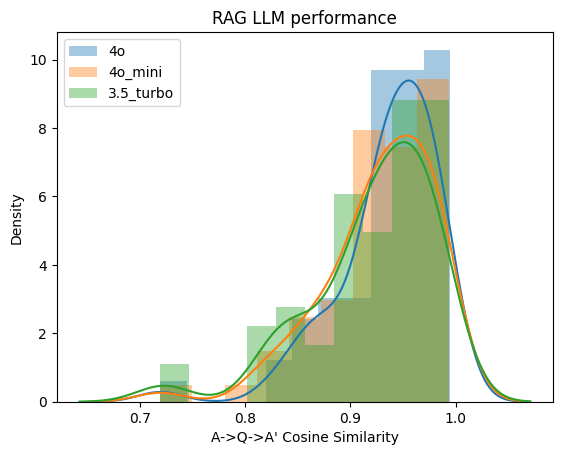

In [20]:
sns.distplot(similarity_4o, label='4o')
sns.distplot(similarity_4o_mini, label='4o_mini')
sns.distplot(similarity_35_turbo, label='3.5_turbo')


plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
# plt.legend()

plt.legend(loc='upper left')
plt.show()